In [ ]:
import operator
import json
import threading
from typing import Annotated, TypedDict
from datetime import datetime

from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.agents import create_agent
from dotenv import load_dotenv
load_dotenv()

In [ ]:
DB_PATH = "./fraud_demo.sqlite3"


class FraudDetectionState(TypedDict):
    return_id: str
    order_id: str
    user_email: str
    return_reason: str
    return_items: list[dict]
    fraud_checks: Annotated[list[dict], operator.add]
    fraud_score: float
    fraud_details: dict
    check_reason: bool
    check_frequency: bool
    check_value: bool

In [50]:
database = SQLDatabase.from_uri(f"sqlite:///{DB_PATH}")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

toolkit = SQLDatabaseToolkit(db=database, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000023C156A3890>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000023C156A3890>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000023C156A3890>),
 QuerySQLCheckerTool(description='Use this tool to 

In [ ]:
system_prompt = """
You are a read-only SQL analyst.
- Only use the provided SQL tools; start by listing tables and relevant schemas.
- Never run DML (INSERT/UPDATE/DELETE/DROP/TRUNCATE).
- Keep queries short (add LIMIT 10 when showing rows) and double-check with the query checker before execution.
- Always respond with valid JSON shaped as {"check_type": str, "risk_score": number, "reason": str, "details": object}.
"""

agent= create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt,
)

In [ ]:
def parse_agent_json(raw_text: str, check_type: str) -> dict:
    try:
        return json.loads(raw_text)
    except Exception:
        return {
            "check_type": check_type,
            "risk_score": 50,
            "reason": "Agent response was not valid JSON",
            "details": {"raw_output": raw_text, "risk_level": "MEDIUM"},
        }

In [ ]:

class ReturnFrequencyState(TypedDict):
    user_email: str




def check_return_frequency(state: ReturnFrequencyState):

    print(threading.current_thread().name, "Checking return frequency")

    prompt = f"""
            Role: SQL fraud checker for return frequency.
            Task: Count returns for this user in the last 30 days where status != 'REJECTED'.
            User: {state['user_email']}
            Scoring rules:
            - >5 returns → HIGH, score 70-100 (cap 100)
            - 3-5 returns → MEDIUM, score 40-60
            - <3 returns → score = count * 10
            Respond ONLY with JSON: {{"check_type": "frequency", "risk_score": number, "reason": string, "details": {{"return_count": n, "period_days": 30, "risk_level": "HIGH|MEDIUM|LOW"}}}}.
            """
    
    resp = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    response_text= resp['messages'][-1].content

    return {"fraud_checks":[parse_agent_json(response_text, "frequency")]}

In [ ]:
class OrderValueState(TypedDict):
    my_order_id: str
    user_email: str
    my_return_items: list[dict]


def check_order_value_patterns(state: OrderValueState):
    print(threading.current_thread().name, "Checking order value patterns")

    prompt = f"""
  Role: SQL fraud checker for return value patterns.
  Task:
  - Compute total_return_value for this order using order_items and the provided product_ids/quantities.
  - Compute high_value_count = returns by this user with refund_amount > 500 and status != 'REJECTED'.
  Inputs: order_id={state['my_order_id']}, user={state['user_email']}, items={state['my_return_items']}.
  Scoring rules (base = the starting score from return value before any history bump):
  - If total > 1000: base = 70 + min(30, (total - 1000) / 10) → cap at 100
  - If 500-1000: base = 40 + ((total - 500) / 500) * 20 (ranges ~40-60)
  - If <500: base = (total / 500) * 30 (ranges ~0-30)
  - After base, if high_value_count > 3: add 20, cap final at 100
  Respond ONLY with JSON: {{"check_type": "value", "risk_score": number, "reason": string, "details": {{"return_value": number, "high_value_history_count": n, "risk_level": "HIGH|MEDIUM|LOW"}}}}.
  """
    
    resp = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    response_text= resp['messages'][-1].content

    return {"fraud_checks":[parse_agent_json(response_text, "value")]}

In [ ]:
class ReasonPatternState(TypedDict):
    my_return_reason: str
    user_email: str


def check_return_reason_patterns(state: ReasonPatternState):
    print(threading.current_thread().name, "Checking return reason patterns")

    prompt = f"""
  Role: SQL + text fraud checker for reason patterns.
  Task: Score the return_reason and user history.
  Reason text: {state['my_return_reason']}
  User: {state['user_email']}
  Rules (additive):
  - Suspicious keywords ("changed mind", "don't need", "don't want", "ordered by mistake", "no reason", "just because") → +40
  - Very short reason (<10 chars) → +30
  - Repeated reasons by same user (usage >2) → +min(30, repeats*10)
  Risk level: HIGH >60, MEDIUM 30-60, else LOW.
  Respond ONLY with JSON: {{"check_type": "reason", "risk_score": number, "reason": string, "details": {{"return_reason": string, "suspicious_keywords": bool, "too_short": bool, "repeated_reasons": n, "risk_level": "HIGH|MEDIUM|LOW"}}}}.
  """
    
    resp = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    response_text= resp['messages'][-1].content

    return {"fraud_checks":[parse_agent_json(response_text, "reason")]}

In [ ]:
def aggregate_fraud_scores(state: FraudDetectionState) -> dict:
    print(threading.current_thread().name, "Aggregating fraud scores")
    
    fraud_checks = state.get("fraud_checks", [])

    if not fraud_checks:
        return {
            "fraud_score": 50.0,
            "fraud_details": {
                "risk_level": "MEDIUM",
                "message": "No checks completed",
                "checks_completed": 0,
            },
        }

    checks_by_type = {c["check_type"]: c for c in fraud_checks}


    weights = {"frequency": 0.40, "value": 0.40, "reason": 0.20,}


    weighted = sum(checks_by_type[t]["risk_score"] * w for t, w in weights.items() if t in checks_by_type)



    total_weight = sum(w for t, w in weights.items() if t in checks_by_type)

    final_score = weighted / total_weight if total_weight else 50.0

    if final_score < 30:
        level, rec = "LOW", "Auto-approve"
    elif final_score < 60:
        level, rec = "MEDIUM", "Recommend admin review"
    else:
        level, rec = "HIGH", "Escalate to admin"

    return {
        "fraud_score": final_score,
        "fraud_details": {
            "risk_level": level,
            "recommendation": rec,
            "checks_completed": len(fraud_checks),
          
        },
    }

In [ ]:
def spwan_fraud_cheks(state: FraudDetectionState) -> list[Send]:
 
 send_list = []
 if state.get("check_frequency", True):
     send_list.append(
         Send("check_return_frequency", ReturnFrequencyState(user_email=state["user_email"]))
     )
 if state.get("check_value", True):
        send_list.append(
            Send("check_order_value_patterns", OrderValueState(
                my_order_id=state["order_id"],
                user_email=state["user_email"],
                my_return_items=state["return_items"],
            ))
        )
 if state.get("check_reason", True):
     send_list.append(
         Send("check_return_reason_patterns", ReasonPatternState(
             my_return_reason=state["return_reason"],
             user_email=state["user_email"],
         ))
     )
 
 
 return send_list

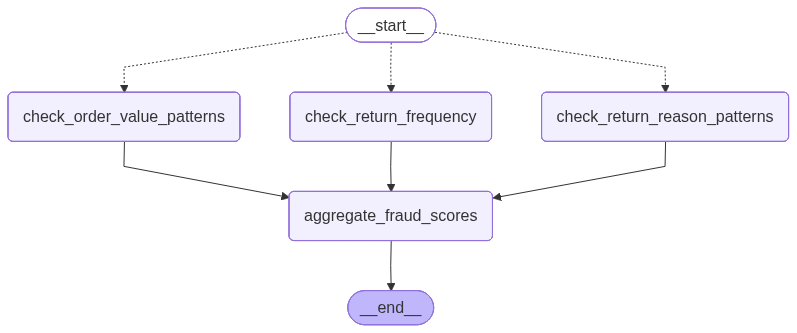

In [31]:
workflow= StateGraph(FraudDetectionState)
workflow.add_node("check_return_frequency", check_return_frequency )
workflow.add_node("check_order_value_patterns", check_order_value_patterns )
workflow.add_node("check_return_reason_patterns", check_return_reason_patterns )
workflow.add_node("aggregate_fraud_scores", aggregate_fraud_scores )

workflow.add_conditional_edges(START, spwan_fraud_cheks,
                               ["check_return_frequency", "check_order_value_patterns", "check_return_reason_patterns"])

workflow.add_edge("check_return_frequency", "aggregate_fraud_scores")
workflow.add_edge("check_order_value_patterns", "aggregate_fraud_scores")
workflow.add_edge("check_return_reason_patterns", "aggregate_fraud_scores")
workflow.add_edge("aggregate_fraud_scores", END)

returns_graph= workflow.compile()
returns_graph

In [ ]:
good_case = {
    "return_id": "RET_GOOD_RUN",
    "order_id": "ORD_GOOD_1",
    "user_email": "good_user@example.com",
    "return_reason": "Product arrived damaged",
    "return_items": [{"product_id": "SKU_LAPTOP", "quantity": 1}],
    "check_frequency": True,
    "check_reason": False,
    "check_value": True

}


result= returns_graph.invoke(good_case)

result

In [ ]:
class OrderAgentState(TypedDict):
 
    message: str
    intent: str
    order_status: str
    payment_status: str
    cancel_allowed: bool
    cancel_result: str
    reply: str

    audit_log : Annotated[list[str],operator.add    ]


    return_id: str
    order_id: str
    user_email: str
    return_decision: str
    return_reason: str
    return_items: list[dict]
   # fraud_checks: Annotated[list[dict], operator.add]
    fraud_score: float
    fraud_details: dict


    check_reason: bool
    check_frequency: bool
    check_value: bool

In [35]:
def detect_intent(state: OrderAgentState):

    text = state.get("message", "").lower()
    if "cancel" in text:
        intent = "cancel"
    elif "return" in text or "refund" in text:
        intent = "return"
    else:
        intent = "status"
        
    return {"intent": intent, "audit_log": [f"intent={intent}"]}

In [36]:
import sqlite3

def fetch_order_snapshot(state: OrderAgentState):
    order_id = state["order_id"]
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("SELECT status, user_email, order_date FROM orders WHERE order_id=?", (order_id,))
    row = cur.fetchone()
    if not row:
        conn.close()
        return {"order_status": None, "audit_log": ["order not found"]}
    status, user_email, order_date = row
    cur.execute("SELECT status FROM payments WHERE order_id=? LIMIT 1", (order_id,))
    pay = cur.fetchone()
    payment_status = pay[0] if pay else None
    cur.execute("SELECT product_id, quantity, unit_price FROM order_items WHERE order_id=?", (order_id,))
    items = [
        {"product_id": p, "quantity": q, "unit_price": u}
        for p, q, u in cur.fetchall()
    ]
    conn.close()
    return {
        "order_status": status,
        "payment_status": payment_status,
        "user_email": user_email,
        "return_items": items,
        "audit_log": [f"order_status={status}", f"payment_status={payment_status}", f"order_date={order_date}"]
    }

In [37]:
def check_cancel_rules(state: OrderAgentState):
    status = state.get("order_status")
    allowed = status not in {"SHIPPED", "DELIVERED", None}
    return {"cancel_allowed": allowed, "audit_log": [f"cancel_allowed={allowed}"]}

In [38]:
def perform_cancellation(state: OrderAgentState):
    if not state.get("cancel_allowed"):
        return {"cancel_result": "Denied: already shipped/delivered or missing order"}
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("UPDATE orders SET status='CANCELLED' WHERE order_id=?", (state["order_id"],))
    cur.execute("UPDATE payments SET status='VOIDED' WHERE order_id=?", (state["order_id"],))
    conn.commit()
    conn.close()
    return {"cancel_result": "Cancelled and payment voided", "audit_log": ["order cancelled, payment voided"]}

In [39]:
def prepare_return(state: OrderAgentState):

    allowed = state.get("order_status") == "DELIVERED"
    reason = state.get("return_reason") or state.get("message", "return request")
    
    return {"return_decision": "eligible" if allowed else "ineligible", "return_reason": reason, "audit_log": [f"return_decision={'eligible' if allowed else 'ineligible'}"]}

In [40]:
def run_fraud_subgraph_node(state: OrderAgentState):

    fraud_State = {
        "return_id": state["return_id"],

        "order_id": state["order_id"],
        "user_email": state["user_email"],
        "return_reason": state["return_reason"],
        "return_items": state["return_items"],
        "check_reason": state.get("check_reason", True),
        "check_frequency": state.get("check_frequency", True),
        "check_value": state.get("check_value", True)
    }

    result= returns_graph.invoke(fraud_State)

    return {
        "fraud_score": result.get("fraud_score"),
        "fraud_details": result.get("fraud_details"),
        "audit_log": [f"fraud_score={result.get('fraud_score')}"]
    }

In [41]:
def finalize(state: OrderAgentState):
    intent = state.get("intent")
    if intent == "status":
        return {
            "reply": f"Order {state['order_id']} is {state.get('order_status')} (payment {state.get('payment_status')})."
        }
    if intent == "cancel":
        return {
            "reply": state.get("cancel_result", "Unable to cancel."),
            "audit_log": [f"done_cancel={state.get('cancel_result')}"]
        }
    if intent == "return":
        score = state.get("fraud_score")
        level = state.get("fraud_details", {}).get("risk_level") if state.get("fraud_details") else None
        decision = "Escalate to manual review" if score and score >= 60 else "Return pre-approved"
        return {
            "reply": f"Return processed. Fraud score={score} ({level}). Decision: {decision}.",
            "return_decision": decision,
            "audit_log": [f"decision={decision}"]
        }
    return {"reply": "Unhandled intent."}


In [43]:
def route_from_intent(state: OrderAgentState):

    intent = state.get("intent")
    
    if intent == "cancel":
        return "check_cancel"
    if intent == "return":
        return "prepare_return"
    return "finalize"


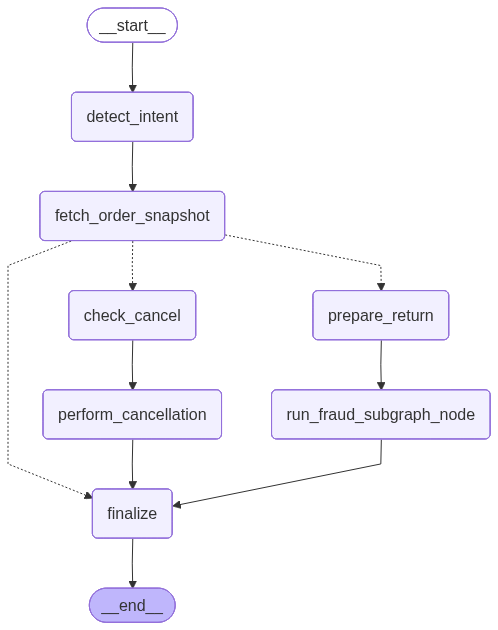

In [44]:
orderworkflow= StateGraph(OrderAgentState)
orderworkflow.add_node("detect_intent", detect_intent )
orderworkflow.add_node("fetch_order_snapshot", fetch_order_snapshot )
orderworkflow.add_node("check_cancel", check_cancel_rules )
orderworkflow.add_node("perform_cancellation", perform_cancellation )
orderworkflow.add_node("run_fraud_subgraph_node", run_fraud_subgraph_node )
orderworkflow.add_node("prepare_return", prepare_return )
orderworkflow.add_node("finalize", finalize )

orderworkflow.add_edge(START, "detect_intent")
orderworkflow.add_edge("detect_intent", "fetch_order_snapshot")

orderworkflow.add_conditional_edges("fetch_order_snapshot", route_from_intent,
                                  ["check_cancel", "prepare_return", "finalize"])
orderworkflow.add_edge("check_cancel", "perform_cancellation")
orderworkflow.add_edge("perform_cancellation", "finalize")
orderworkflow.add_edge("prepare_return", "run_fraud_subgraph_node")
orderworkflow.add_edge("run_fraud_subgraph_node", "finalize")
orderworkflow.add_edge("finalize", END)

ordergraph=orderworkflow.compile()
ordergraph

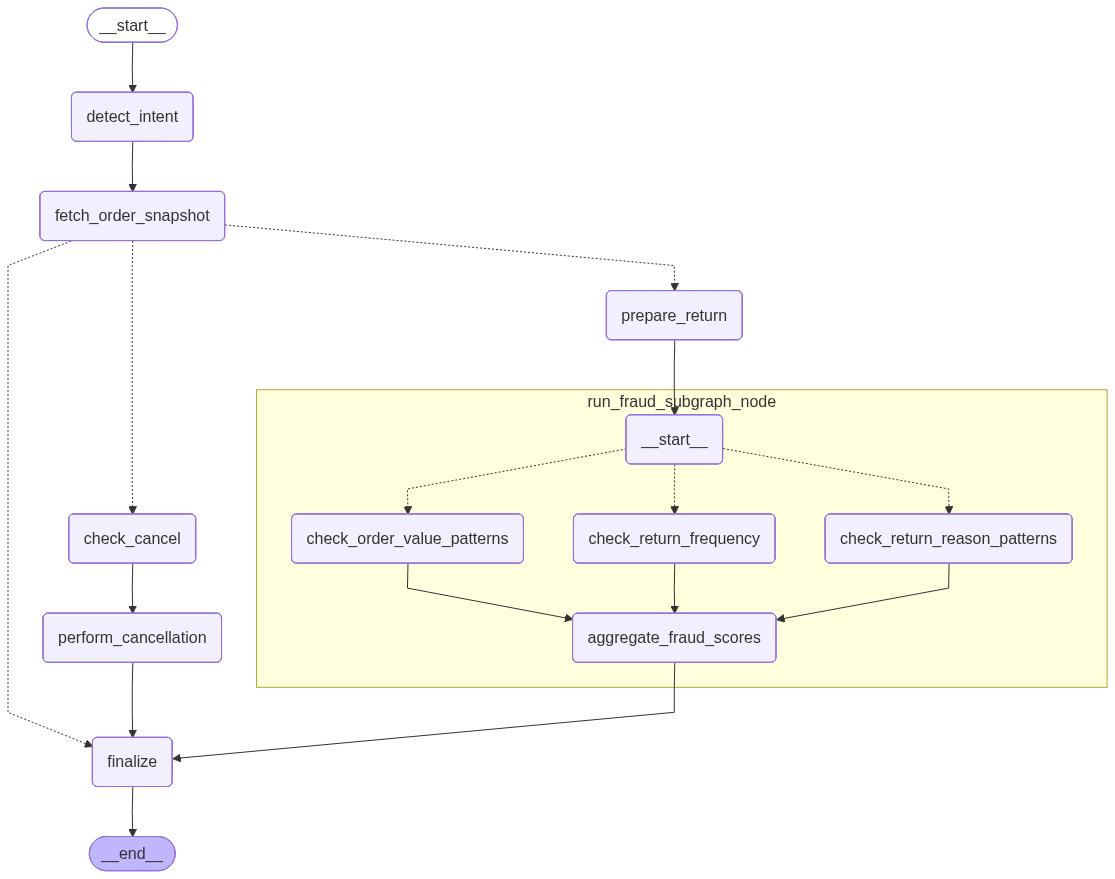

In [49]:
from IPython.display import Image,display

display(Image(ordergraph.get_graph(xray=1).draw_mermaid_png()))